# Artificial and Computational Intelligence

Problem statement
Given the below maze configuration, the task of the robot is to navigate in the maze and find
the optimal path to reach the finish position. It can move to the north, south, west and east
direction. While navigating through the environment it has obstacles like walls. For each
transition, a path cost of +3 is added in search. Assume that the robot’s vision sensors are
sensitive to the exposure to the sunlight and whenever it tries to move towards the east
direction resulting in incurring an additional penalty of +5 cost. Use Manhattan distance as a
heuristic wherever necessary.

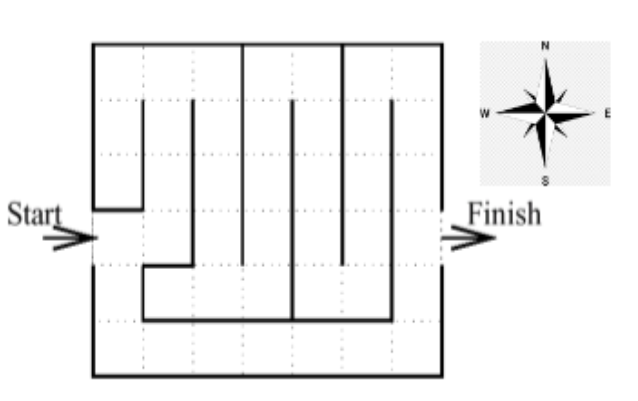


## Problem solving by Iterative Deepening A* and/or Hill Climbing

Things to follow
1.	Use appropriate data structures to represent the graph and the path using python libraries
2.	Provide proper documentation
3.	Find the path and print it

Coding begins here

### 1.	Define the environment in the following block

List the PEAS decription of the problem here in this markdown block
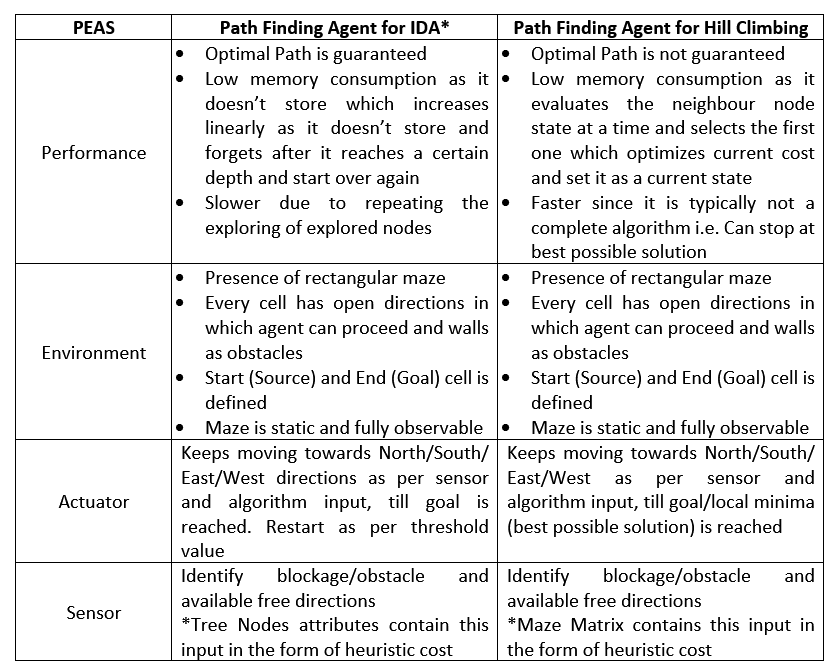

Design the agent as PSA Agent(Problem Solving Agent) 
Clear Initial data structures to define the graph and variable declarations is expected 
IMPORTATANT: Write distinct code block as below

In [1]:
#Code Block : Set Initial State (Must handle dynamic inputs)

from queue import PriorityQueue  # for IDA* algo
from tkinter import * # for GUI
from enum import Enum # for color specification
import time

INFINITY = 10000000 # for large number to define inf cost
cameFrom = {}

In [2]:
#Code Block : Set the matrix for transition & cost (as relevant for the given problem)

class COLOR(Enum):
    '''
    This class is created to use the Tkinter colors easily.
    Each COLOR object has two color values.
    The first two objects (dark and light) are for theme and the two color 
    values represent the Canvas color and the Maze Line color respectively.
    The rest of the colors are for Agents.
    The first value is the color of the Agent and the second is the color of
    its footprint
    '''
    dark = ('gray11', 'white')
    light = ('white', 'black')
    black = ('black', 'dim gray')
    red = ('red3', 'tomato')
    cyan = ('cyan4', 'cyan4')
    green = ('green4', 'pale green')
    blue = ('DeepSkyBlue4', 'DeepSkyBlue2')
    yellow = ('yellow2', 'yellow2')

class textLabel:
    '''
    This class is to create Text Label to show different results in GUI.
    '''

    def __init__(self, parentMaze, title, value):
        '''
        parentmaze-->   The maze on which Label will be displayed.
        title-->        The title of the value to be displayed
        value-->        The value to be displayed
        '''
        self.title = title
        self._value = value
        self._parentMaze = parentMaze        
        self._var = None
        self.drawLabel()

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, v):
        self._value = v
        self._var.set(f'{self.title} : {v}')

    def drawLabel(self):
        self._var = StringVar()
        self.lab = Label(self._parentMaze._canvas, textvariable=self._var, bg="white", fg="black",
                         font=('Helvetica bold', 12), relief=RIDGE)
        self._var.set(f'{self.title} : {self.value}')
        self.lab.pack(expand=True, side=LEFT, anchor=NW)

class agent:
    '''
    The agents can be placed on the maze.
    They can represent the virtual object just to indcate the cell selected in Maze.
    Or they can be the physical agents (like robots)    
    '''
    # agent(self, *self._goal, shape='square', filled=True, color=COLOR.green)
    def __init__(self, parentMaze, x=None, y=None, shape='square', goal=None, filled=False, footprints=False,
                 color: COLOR = COLOR.blue):
        '''
        parentmaze-->  The maze on which agent is placed.
        x,y-->  Position of the agent i.e. cell inside which agent will be placed                
        shape-->    square (as string)
        goal-->     Default value is the goal of the Maze
        filled-->   For square shape, filled=False is a smaller square
                    While filled =True is a bigger square filled in complete Cell                    
        footprints-->   When the aganet will move to some other cell, its footprints
                        on the previous cell can be placed by making this True
        color-->    Color of the agent.                
        '''
        self._parentMaze = parentMaze
        self.color = color
        if (isinstance(color, str)):
            if (color in COLOR.__members__):
                self.color = COLOR[color]
            else:
                raise ValueError(f'{color} is not a valid COLOR!')
        self.filled = filled
        self.shape = shape
        self._orient = 0
        if x is None:
            x = parentMaze.rows
            print('\nAgent''s x : ', x, end=" ")
        if y is None:
            y = parentMaze.cols
            print('y : ', y)
        self.x = x
        self.y = y
        self.footprints = footprints
        self._parentMaze._agents.append(self)
        if goal == None:
            self.goal = self._parentMaze._goal
        else:
            self.goal = goal
        self._body = []
        self.position = (self.x, self.y)

    @property
    def x(self):
        return self._x

    @x.setter
    def x(self, newX):
        self._x = newX

    @property
    def y(self):
        return self._y
    
    # To define the location of the agent with respect to parent maze (GUI canvas)
    @y.setter
    def y(self, newY):
        self._y = newY
        w = self._parentMaze._cell_width
        x = self.x * w - w + self._parentMaze._LabWidth
        y = self.y * w - w + self._parentMaze._LabWidth
        if self.shape == 'square':
            if self.filled:
                self._coord = (y, x, y + w, x + w)
            else:
                self._coord = (y + w / 2.5, x + w / 2.5, y + w / 2.5 + w / 4, x + w / 2.5 + w / 4)
        else:
            self._coord = (y + w / 2, x + 3 * w / 9, y + w / 2, x + 3 * w / 9 + w / 4)

        if (hasattr(self, '_head')):
            if self.footprints is False:
                self._parentMaze._canvas.delete(self._head)
            else:
                if self.shape == 'square':
                    self._parentMaze._canvas.itemconfig(self._head, fill=self.color.value[1], outline="")
                    self._parentMaze._canvas.tag_raise(self._head)
                    try:
                        self._parentMaze._canvas.tag_lower(self._head, 'ov')
                    except:
                        pass
                    if self.filled:
                        lll = self._parentMaze._canvas.coords(self._head)
                        oldcell = (round(((lll[1] - 26) / self._parentMaze._cell_width) + 1),
                                   round(((lll[0] - 26) / self._parentMaze._cell_width) + 1))
                        self._parentMaze._redrawCell(*oldcell, self._parentMaze.theme)
                else:
                    self._parentMaze._canvas.itemconfig(self._head, fill=self.color.value[1])  # ,outline='gray70')
                    self._parentMaze._canvas.tag_raise(self._head)
                    try:
                        self._parentMaze._canvas.tag_lower(self._head, 'ov')
                    except:
                        pass
                self._body.append(self._head)
            if not self.filled or self.shape == 'arrow':
                if self.shape == 'square':
                    self._head = self._parentMaze._canvas.create_rectangle(*self._coord, fill=self.color.value[0],
                                                                           outline='')  
                    try:
                        self._parentMaze._canvas.tag_lower(self._head, 'ov')
                    except:
                        pass
                else:
                    self._head = self._parentMaze._canvas.create_line(*self._coord, fill=self.color.value[0],
                                                                      arrow=FIRST, arrowshape=(
                            3 / 10 * w, 4 / 10 * w, 4 / 10 * w))  # ,outline=self.color.name)
                    try:
                        self._parentMaze._canvas.tag_lower(self._head, 'ov')
                    except:
                        pass
                    o = self._orient % 4
                    if o == 1:
                        self._RCW()
                        self._orient -= 1
                    elif o == 3:
                        self._RCCW()
                        self._orient += 1
                    elif o == 2:
                        self._RCCW()
                        self._RCCW()
                        self._orient += 2
            else:
                self._head = self._parentMaze._canvas.create_rectangle(*self._coord, fill=self.color.value[0],
                                                                       outline='')  
                try:
                    self._parentMaze._canvas.tag_lower(self._head, 'ov')
                except:
                    pass
                self._parentMaze._redrawCell(self.x, self.y, theme=self._parentMaze.theme)
        else:
            self._head = self._parentMaze._canvas.create_rectangle(*self._coord, fill=self.color.value[0],
                                                                   outline='')  
            try:
                self._parentMaze._canvas.tag_lower(self._head, 'ov')
            except:
                pass
            self._parentMaze._redrawCell(self.x, self.y, theme=self._parentMaze.theme)

    @property
    def position(self):
        return (self.x, self.y)

    @position.setter
    def position(self, newpos):
        self.x = newpos[0]
        self.y = newpos[1]
        self._position = newpos

    def _RCCW(self):
        '''
        To Rotate the agent in Counter Clock Wise direction
        '''

        def pointNew(p, newOrigin):
            return (p[0] - newOrigin[0], p[1] - newOrigin[1])

        w = self._parentMaze._cell_width
        x = self.x * w - w + self._parentMaze._LabWidth
        y = self.y * w - w + self._parentMaze._LabWidth
        cent = (y + w / 2, x + w / 2)
        p1 = pointNew((self._coord[0], self._coord[1]), cent)
        p2 = pointNew((self._coord[2], self._coord[3]), cent)
        p1CW = (p1[1], -p1[0])
        p2CW = (p2[1], -p2[0])
        p1 = p1CW[0] + cent[0], p1CW[1] + cent[1]
        p2 = p2CW[0] + cent[0], p2CW[1] + cent[1]
        self._coord = (*p1, *p2)
        self._parentMaze._canvas.coords(self._head, *self._coord)
        self._orient = (self._orient - 1) % 4

    def _RCW(self):
        '''
        To Rotate the agent in Clock Wise direction
        '''

        def pointNew(p, newOrigin):
            return (p[0] - newOrigin[0], p[1] - newOrigin[1])

        w = self._parentMaze._cell_width
        x = self.x * w - w + self._parentMaze._LabWidth
        y = self.y * w - w + self._parentMaze._LabWidth
        cent = (y + w / 2, x + w / 2)
        p1 = pointNew((self._coord[0], self._coord[1]), cent)
        p2 = pointNew((self._coord[2], self._coord[3]), cent)
        p1CW = (-p1[1], p1[0])
        p2CW = (-p2[1], p2[0])
        p1 = p1CW[0] + cent[0], p1CW[1] + cent[1]
        p2 = p2CW[0] + cent[0], p2CW[1] + cent[1]
        self._coord = (*p1, *p2)
        self._parentMaze._canvas.coords(self._head, *self._coord)
        self._orient = (self._orient + 1) % 4

    def moveRight(self, event):
        if self._parentMaze.maze_map[self.x, self.y]['E'] == True:
            self.y = self.y + 1

    def moveLeft(self, event):
        if self._parentMaze.maze_map[self.x, self.y]['W'] == True:
            self.y = self.y - 1

    def moveUp(self, event):
        if self._parentMaze.maze_map[self.x, self.y]['N'] == True:
            self.x = self.x - 1
            self.y = self.y

    def moveDown(self, event):
        if self._parentMaze.maze_map[self.x, self.y]['S'] == True:
            self.x = self.x + 1
            self.y = self.y

class maze:
    '''
    This is the main class to create maze.
    '''

    def __init__(self, rows=10, cols=10):
        '''
        rows--> No. of rows of the maze
        cols--> No. of columns of the maze
        Need to pass just the two arguments. The rest will be assigned automatically
        maze_map--> Will be set to a Dictionary. Keys will be cells and
                    values will be another dictionary with keys=['N','S','E','W'] for
                    North South East West and values will be 0 or 1. 
                    0 means that direction(NSEW) is blocked. 
                    1 means that direction is open.
        grid--> A list of all cells
        path--> Shortest path from start(source) to goal
                It will be a dictionary
        _win,_cell_width,_canvas -->    _win and canvas are for Tkinter window and canvas
                                        _cell_width is cell width calculated automatically
        _agents-->  A list of agents on the maze
        markedCells-->  Will be used to mark some particular cell during
                        path trace by the agent.
        _
        '''
        self.rows = rows
        self.cols = cols
        self.maze_map = {}
        self.grid = []
        self.path = {}
        self._cell_width = 50
        self._win = None
        self._canvas = None
        self._agents = []
        self.markCells = []

    @property
    def grid(self):
        return self._grid

    @grid.setter
    def grid(self, n):
        self._grid = []
        y = 0
        for n in range(self.cols):
            x = 1
            y = 1 + y
            for m in range(self.rows):
                self.grid.append((x, y))
                self.maze_map[x, y] = {'E': 0, 'W': 0, 'N': 0, 'S': 0}
                x = x + 1

    def _Open_East(self, x, y):
        '''
        To remove the East Wall of the cell
        '''
        self.maze_map[x, y]['E'] = 1
        if y + 1 <= self.cols:
            self.maze_map[x, y + 1]['W'] = 1

    def _Open_West(self, x, y):
        self.maze_map[x, y]['W'] = 1
        if y - 1 > 0:
            self.maze_map[x, y - 1]['E'] = 1

    def _Open_North(self, x, y):
        self.maze_map[x, y]['N'] = 1
        if x - 1 > 0:
            self.maze_map[x - 1, y]['S'] = 1

    def _Open_South(self, x, y):
        self.maze_map[x, y]['S'] = 1
        if x + 1 <= self.rows:
            self.maze_map[x + 1, y]['N'] = 1

    def CreateMaze(self, start_=(1,1),fin_=(1,1), pattern=None, loopPercent=0, saveMaze=False, loadMaze=None,
                   theme: COLOR = COLOR.dark, maze_map_raw={}):
        '''   
        Maze matrix is passed as a dictionary along with start(source) and goal cell
        theme--> Dark or Light
        '''
        _stack = []
        _closed = []
        self.theme = theme
        self._goal = fin_
        self._start = start_
        if (isinstance(theme, str)):
            if (theme in COLOR.__members__):
                self.theme = COLOR[theme]
            else:
                raise ValueError(f'{theme} is not a valid theme COLOR!')

        def blockedNeighbours(cell):
            n = []
            for d in self.maze_map[cell].keys():
                if self.maze_map[cell][d] == 0:
                    if d == 'E' and (cell[0], cell[1] + 1) in self.grid:
                        n.append((cell[0], cell[1] + 1))
                    elif d == 'W' and (cell[0], cell[1] - 1) in self.grid:
                        n.append((cell[0], cell[1] - 1))
                    elif d == 'N' and (cell[0] - 1, cell[1]) in self.grid:
                        n.append((cell[0] - 1, cell[1]))
                    elif d == 'S' and (cell[0] + 1, cell[1]) in self.grid:
                        n.append((cell[0] + 1, cell[1]))
            return n

        def removeWallinBetween(cell1, cell2):
            '''
            To remove wall in between two cells
            '''
            if cell1[0] == cell2[0]:
                if cell1[1] == cell2[1] + 1:
                    self.maze_map[cell1]['W'] = 1
                    self.maze_map[cell2]['E'] = 1
                else:
                    self.maze_map[cell1]['E'] = 1
                    self.maze_map[cell2]['W'] = 1
            else:
                if cell1[0] == cell2[0] + 1:
                    self.maze_map[cell1]['N'] = 1
                    self.maze_map[cell2]['S'] = 1
                else:
                    self.maze_map[cell1]['S'] = 1
                    self.maze_map[cell2]['N'] = 1

        def isCyclic(cell1, cell2):
            '''
            To avoid too much blank(clear) path.
            '''
            ans = False
            if cell1[0] == cell2[0]:
                if cell1[1] > cell2[1]: cell1, cell2 = cell2, cell1
                if self.maze_map[cell1]['S'] == 1 and self.maze_map[cell2]['S'] == 1:
                    if (cell1[0] + 1, cell1[1]) in self.grid and self.maze_map[(cell1[0] + 1, cell1[1])]['E'] == 1:
                        ans = True
                if self.maze_map[cell1]['N'] == 1 and self.maze_map[cell2]['N'] == 1:
                    if (cell1[0] - 1, cell1[1]) in self.grid and self.maze_map[(cell1[0] - 1, cell1[1])]['E'] == 1:
                        ans = True
            else:
                if cell1[0] > cell2[0]: cell1, cell2 = cell2, cell1
                if self.maze_map[cell1]['E'] == 1 and self.maze_map[cell2]['E'] == 1:
                    if (cell1[0], cell1[1] + 1) in self.grid and self.maze_map[(cell1[0], cell1[1] + 1)]['S'] == 1:
                        ans = True
                if self.maze_map[cell1]['W'] == 1 and self.maze_map[cell2]['W'] == 1:
                    if (cell1[0], cell1[1] - 1) in self.grid and self.maze_map[(cell1[0], cell1[1] - 1)]['S'] == 1:
                        ans = True
            return ans

        self.maze_map = maze_map_raw
        self._drawMaze(self.theme)
        agent(self, *self._goal, shape='square', filled=True, color=COLOR.green)
        agent(self, *self._start, shape='square', filled=True, color=COLOR.yellow)

    def _drawMaze(self, theme):
        '''
        Creation of Tkinter window and maze lines
        '''

        self._LabWidth = 26  # Space from the top for Labels
        self._win = Tk()
        self._win.state('zoomed')
        self._win.title('ACI Maze')

        scr_width = self._win.winfo_screenwidth()
        scr_height = self._win.winfo_screenheight()
        self._win.geometry(f"{scr_width}x{scr_height}+0+0")
        self._canvas = Canvas(width=scr_width, height=scr_height, bg=theme.value[0])  # 0,0 is top left corner
        self._canvas.pack(expand=YES, fill=BOTH)
        # Some calculations for calculating the width of the maze cell
        k = 3.25
        if self.rows >= 95 and self.cols >= 95:
            k = 0
        elif self.rows >= 80 and self.cols >= 80:
            k = 1
        elif self.rows >= 70 and self.cols >= 70:
            k = 1.5
        elif self.rows >= 50 and self.cols >= 50:
            k = 2
        elif self.rows >= 35 and self.cols >= 35:
            k = 2.5
        elif self.rows >= 22 and self.cols >= 22:
            k = 3
        self._cell_width = round(min(((scr_height - self.rows - k * self._LabWidth) / (self.rows)),
                                     ((scr_width - self.cols - k * self._LabWidth) / (self.cols)), 90), 3)

        # Creating Maze lines
        if self._win is not None:
            if self.grid is not None:
                for cell in self.grid:
                    x, y = cell
                    w = self._cell_width
                    x = x * w - w + self._LabWidth
                    y = y * w - w + self._LabWidth
                    if self.maze_map[cell]['E'] == False:
                        l = self._canvas.create_line(y + w, x, y + w, x + w, width=2, fill=theme.value[1], tag='line')
                    if self.maze_map[cell]['W'] == False:
                        l = self._canvas.create_line(y, x, y, x + w, width=2, fill=theme.value[1], tag='line')
                    if self.maze_map[cell]['N'] == False:
                        l = self._canvas.create_line(y, x, y + w, x, width=2, fill=theme.value[1], tag='line')
                    if self.maze_map[cell]['S'] == False:
                        l = self._canvas.create_line(y, x + w, y + w, x + w, width=2, fill=theme.value[1], tag='line')

    def _redrawCell(self, x, y, theme):
        '''
        To redraw a cell.
        With Full sized square agent, it can overlap with maze lines
        So the cell is redrawn so that cell lines are on top
        '''
        w = self._cell_width
        cell = (x, y)
        x = x * w - w + self._LabWidth
        y = y * w - w + self._LabWidth
        if self.maze_map[cell]['E'] == False:
            self._canvas.create_line(y + w, x, y + w, x + w, width=2, fill=theme.value[1])
        if self.maze_map[cell]['W'] == False:
            self._canvas.create_line(y, x, y, x + w, width=2, fill=theme.value[1])
        if self.maze_map[cell]['N'] == False:
            self._canvas.create_line(y, x, y + w, x, width=2, fill=theme.value[1])
        if self.maze_map[cell]['S'] == False:
            self._canvas.create_line(y, x + w, y + w, x + w, width=2, fill=theme.value[1])

    _tracePathList = []

    def _tracePathSingle(self, a, p, kill, showMarked, delay):
        '''
        An interal method to help tracePath method for tracing a path by agent.
        '''

        def killAgent(a):
            '''
            if the agent should be killed after it reaches the Goal or completes the path
            '''
            #for i in range(len(a._body)):
             #   self._canvas.delete(a._body[i])
            #self._canvas.delete(a._head)
            time.sleep(5)
            self._win.destroy()

        w = self._cell_width
        if ((a.x, a.y) in self.markCells and showMarked):
            w = self._cell_width
            x = a.x * w - w + self._LabWidth
            y = a.y * w - w + self._LabWidth
            self._canvas.create_oval(y + w / 2.5 + w / 20, x + w / 2.5 + w / 20, y + w / 2.5 + w / 4 - w / 20,
                                     x + w / 2.5 + w / 4 - w / 20, fill='red', outline='red', tag='ov')
            self._canvas.tag_raise('ov')

        if (a.x, a.y) == (a.goal):
            del maze._tracePathList[0][0][a]
            if maze._tracePathList[0][0] == {}:
                del maze._tracePathList[0]
                if len(maze._tracePathList) > 0:
                    self.tracePath(maze._tracePathList[0][0], kill=maze._tracePathList[0][1],
                                   delay=maze._tracePathList[0][2])
            if kill:
                self._win.after(1000, killAgent, a)
            return
        # If path is provided as dictionary
        if (type(p) == dict):
            if (len(p) == 0):
                del maze._tracePathList[0][0][a]
                return
            if a.shape == 'arrow':
                old = (a.x, a.y)
                # print('old - ',old)
                # print('p - ',p)
                new = p[(a.x, a.y)]
                # print('new - ', new)

                o = a._orient

                if old != new:
                    if old[0] == new[0]:
                        if old[1] > new[1]:
                            mov = 3  # 'W' #3
                        else:
                            mov = 1  # 'E' #1
                    else:
                        if old[0] > new[0]:
                            mov = 0  # 'N' #0

                        else:
                            mov = 2  # 'S' #2
                    if mov - o == 2:
                        a._RCW()

                    if mov - o == -2:
                        a._RCW()
                    if mov - o == 1:
                        a._RCW()
                    if mov - o == -1:
                        a._RCCW()
                    if mov - o == 3:
                        a._RCCW()
                    if mov - o == -3:
                        a._RCW()
                    if mov == o:
                        a.x, a.y = p[(a.x, a.y)]
                else:
                    del p[(a.x, a.y)]
            else:
                # print(p[(a.x, a.y)])
                a.x, a.y = p[(a.x, a.y)]
        # If path is provided as String
        if (type(p) == str):
            if (len(p) == 0):
                del maze._tracePathList[0][0][a]
                if maze._tracePathList[0][0] == {}:
                    del maze._tracePathList[0]
                    if len(maze._tracePathList) > 0:
                        self.tracePath(maze._tracePathList[0][0], kill=maze._tracePathList[0][1],
                                       delay=maze._tracePathList[0][2])
                if kill:
                    self._win.after(300, killAgent, a)
                return
            if a.shape == 'arrow':
                old = (a.x, a.y)
                new = p[0]
                o = a._orient
                if new == 'N':
                    mov = 0
                elif new == 'E':
                    mov = 1
                elif new == 'S':
                    mov = 2
                elif new == 'W':
                    mov = 3

                if mov - o == 2:
                    a._RCW()

                if mov - o == -2:
                    a._RCW()
                if mov - o == 1:
                    a._RCW()
                if mov - o == -1:
                    a._RCCW()
                if mov - o == 3:
                    a._RCCW()
                if mov - o == -3:
                    a._RCW()
            if a.shape == 'square' or mov == o:
                move = p[0]
                if move == 'E':
                    if a.y + 1 <= self.cols:
                        a.y += 1
                elif move == 'W':
                    if a.y - 1 > 0:
                        a.y -= 1
                elif move == 'N':
                    if a.x - 1 > 0:
                        a.x -= 1
                        a.y = a.y
                elif move == 'S':
                    if a.x + 1 <= self.rows:
                        a.x += 1
                        a.y = a.y
                elif move == 'C':
                    a._RCW()
                elif move == 'A':
                    a._RCCW()
                p = p[1:]
        # If path is provided as List
        if (type(p) == list):
            if (len(p) == 0):
                del maze._tracePathList[0][0][a]
                if maze._tracePathList[0][0] == {}:
                    del maze._tracePathList[0]
                    if len(maze._tracePathList) > 0:
                        self.tracePath(maze._tracePathList[0][0], kill=maze._tracePathList[0][1],
                                       delay=maze._tracePathList[0][2])
                if kill:
                    self._win.after(300, killAgent, a)
                return
            if a.shape == 'arrow':
                old = (a.x, a.y)
                new = p[0]
                o = a._orient

                if old != new:
                    if old[0] == new[0]:
                        if old[1] > new[1]:
                            mov = 3  # 'W' #3
                        else:
                            mov = 1  # 'E' #1
                    else:
                        if old[0] > new[0]:
                            mov = 0  # 'N' #0

                        else:
                            mov = 2  # 'S' #2
                    if mov - o == 2:
                        a._RCW()

                    elif mov - o == -2:
                        a._RCW()
                    elif mov - o == 1:
                        a._RCW()
                    elif mov - o == -1:
                        a._RCCW()
                    elif mov - o == 3:
                        a._RCCW()
                    elif mov - o == -3:
                        a._RCW()
                    elif mov == o:
                        a.x, a.y = p[0]
                        del p[0]
                else:
                    del p[0]
            else:
                a.x, a.y = p[0]
                del p[0]

        self._win.after(delay, self._tracePathSingle, a, p, kill, showMarked, delay)

    def tracePath(self, d, kill=False, delay=500, showMarked=False):
        '''
        A method to trace path by agent        
        '''
        self._tracePathList.append((d, kill, delay))
        if maze._tracePathList[0][0] == d:
            for a, p in d.items():
                if a.goal != (a.x, a.y) and len(p) != 0:
                    self._tracePathSingle(a, p, kill, showMarked, delay)

    def run(self):
        '''
        Finally to run the Tkinter Main Loop
        '''
        self._win.attributes('-topmost', 1)
        self._win.mainloop()

In [3]:
#Code Block : Write function to design the Transition Model/Successor function. Ideally this would be called while search algorithms are implemented

# To find the neighbouring cell 
def successors(node):
    neighbours = []
    for item in E:       
        if node == item[0]:
            neighbours.append(item[1])
    return neighbours
# To reconstruct last path for IDA* algo
def reconstruct_path(cameFrom, current):
    total_path = [current]
    cost_idastar = 0
    while current in cameFrom:
        current = cameFrom[current]        
        total_path.append(current)   
    path_temp = total_path.copy()   
    path_temp.reverse()

    for i in range(len(path_temp)-1):        
        cost_idastar += E[path_temp[i],path_temp[i+1]]
    return total_path,cost_idastar

In [4]:
# Code block : Write fucntion to handle goal test (Must handle dynamic inputs). 
# Ideally this would be called while search algorithms are implemented
# Written within the algorithm function itself

def distance(cell1, cell2):
    '''
    Manhattan distance calculation
    '''

    x1, y1 = cell1
    x2, y2 = cell2
    cost=0
    if y2-y1 >0:
        cost += 5*abs(y1 - y2)
    cost+=3*abs(x1 - x2)
    cost+=3*abs(y1 - y2)

    return cost

def maze_cost(maze_map, start_, goal_):
    '''
    Conversion of maze matix to graph with path costs for 
    IDA* algorithm execution
    '''
    currCell = start_
    x1,y1 = currCell[0],currCell[1]
    E = {}
    
    open = PriorityQueue()
    open.put(start_)

    g_score = {row: float("inf") for row in m.grid}
    g_score[start_] = 0
    f_score = {row: float("inf") for row in m.grid}
    f_score[start_] = distance(start_, goal_)

    goal_flag = 0
    
    def search_node(currCell):
        currCell = open.get()        
        if currCell == goal_:
            goal_flag = 1
            # print("GOAL") # for debuging
            return

        for d in 'ESNW':           
            # print(d,'-',maze_map[currCell][d]) # for debuging
            if maze_map[currCell][d] == True:
                if d == 'E':
                    childCell = (currCell[0], currCell[1] + 1)
                elif d == 'W':
                    childCell = (currCell[0], currCell[1] - 1)
                elif d == 'N':
                    childCell = (currCell[0] - 1, currCell[1])
                elif d == 'S':
                    childCell = (currCell[0] + 1, currCell[1])
                
                temp_g_score = g_score[currCell] + distance(currCell, childCell) 
                temp_f_score = temp_g_score + distance(childCell, goal_) # f = g + h for IDA*

                if temp_f_score < f_score[childCell]:
                    f_sc = f_score[childCell]                    
                    g_score[childCell] = temp_g_score
                    f_score[childCell] = temp_g_score + distance(childCell, goal_)                    
                    E[(currCell, childCell)] = distance(currCell, childCell)
                    open.put(childCell)
                    search_node(childCell)

            else:
                count = 0
                for i in 'ESNW':
                    if maze_map[currCell][i] == False:
                        count += 1
                if count == 4:                    
                    return
    search_node(currCell)    
    return E

def map_Heur(goal_ ,maze_rows,maze_cols):
    '''
    Heuristic cost calculation of every node in maze
    '''
    V = {}
    # maze_rows, maze_cols = 6,7    # Kept for debugging

    for i in range(maze_rows):
        for j in range(maze_cols):
            currCell = (i+1,j+1)            
            h = distance(currCell,goal_)            
            V[currCell] = h
    return V

# Heuristic cost of cell passed
def h(node):    
    return V[node]
# Path cost of cell passed
def cost(node, succ):
    return E[node, succ]

### 2.	Definition of Algorithm 1 (Iterative Deepening A* Algorithm)

In [5]:
#Code Block : Function for algorithm 1 implementation

# Defining IDA* algorithm
def ida_star(root, goal):
    global cameFrom
    global all_nodes
    all_nodes = [root]
    def search(node, g, bound):        
        all_nodes.append(node)
        min_node = None
        global cameFrom
        f = g + h(node)
        if f > bound: return f
        if node == goal:            
            return "FOUND"
        minn = INFINITY
        for succ in successors(node):
            t = search(succ, g + cost(node, succ), bound)
            if t == "FOUND":
                cameFrom[succ] = node
                return "FOUND"
            if t < minn:
                minn = t
                min_node = succ
        cameFrom[min_node] = node        
        return minn

    bound = h(root)
    count = 1
    while 1:        
        count += 1
        t = search(root, 0, bound)
        if t == "FOUND":            
            total_path,cost_idastar = reconstruct_path(cameFrom, goal)
            total_path.append(start_)
            return bound,cameFrom,total_path,all_nodes,cost_idastar
        if t == INFINITY: return "NOT_FOUND"
        bound = t

### 3.	Definition of Algorithm 2 (Hill Climbing Algorithm)

In [6]:
#Code Block : Function for algorithm 2 implementation

# Defining Hill Climb algorithm
def hillclimb(m, start=(1,1)):
    if start_ is None:
        start = (m.rows, m.cols)
        print('Default START!!')
    tot_cost = 0
    open = []
    open.append(start)
    aPath = {}
    g_score = {row: float("inf") for row in m.grid}
    g_score[start] = 0
    f_score = {row: float("inf") for row in m.grid}
    f_score[start] = distance(start, goal_)
    searchPath = []
    fwdPath = []
    temp_cell = start
    while 1:
        currCell = temp_cell
        searchPath.append(currCell)
        fwdPath.append(currCell)
        if currCell == m._goal:
            break
        temp_f = 10000
        for d in 'ESNW':
            if m.maze_map[currCell][d] == True:
                if d == 'E':
                    childCell = (currCell[0], currCell[1] + 1)
                elif d == 'W':
                    childCell = (currCell[0], currCell[1] - 1)
                elif d == 'N':
                    childCell = (currCell[0] - 1, currCell[1])
                elif d == 'S':
                    childCell = (currCell[0] + 1, currCell[1])

                temp_f_score = distance(childCell, m._goal)
                searchPath.append(childCell)
                if(temp_f_score < temp_f):
                    temp_cell = childCell
                    temp_f = temp_f_score
        
        if temp_f < distance(currCell, m._goal):           
            aPath[childCell] = temp_cell
            f_score[childCell] = distance(childCell, m._goal)
            open.append(childCell)
            tot_cost += distance(currCell, temp_cell)
        elif temp_f != 10000:
            break

    return searchPath, aPath, fwdPath, tot_cost

### DYNAMIC INPUT

IMPORTANT : Dynamic Input must be got in this section. Display the possible states to choose from:
This is applicable for all the relevent problems as mentioned in the question. 

In [7]:
#Code Block : Function & call to get inputs (start/end state)

#Creating a dictionary as per the given problem statement starting with (1,1) position
maze_map = {
                (1, 1): {'N': 0, 'S': 1, 'E': 1, 'W': 0},
                (2, 1): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (3, 1): {'N': 1, 'S': 0, 'E': 0, 'W': 0},
                (4, 1): {'N': 0, 'S': 1, 'E': 1, 'W': 0},
                (5, 1): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (6, 1): {'N': 1, 'S': 0, 'E': 1, 'W': 0},
                (1, 2): {'N': 0, 'S': 1, 'E': 1, 'W': 1},
                (2, 2): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (3, 2): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (4, 2): {'N': 1, 'S': 0, 'E': 0, 'W': 1},
                (5, 2): {'N': 0, 'S': 0, 'E': 1, 'W': 0},
                (6, 2): {'N': 0, 'S': 0, 'E': 1, 'W': 1},
                (1, 3): {'N': 0, 'S': 1, 'E': 0, 'W': 1},
                (2, 3): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (3, 3): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (4, 3): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (5, 3): {'N': 1, 'S': 0, 'E': 1, 'W': 1},
                (6, 3): {'N': 0, 'S': 0, 'E': 1, 'W': 1},
                (1, 4): {'N': 0, 'S': 1, 'E': 1, 'W': 0},
                (2, 4): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (3, 4): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (4, 4): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (5, 4): {'N': 1, 'S': 0, 'E': 0, 'W': 1},
                (6, 4): {'N': 0, 'S': 0, 'E': 1, 'W': 1},
                (1, 5): {'N': 0, 'S': 1, 'E': 0, 'W': 1},
                (2, 5): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (3, 5): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (4, 5): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (5, 5): {'N': 1, 'S': 0, 'E': 1, 'W': 0},
                (6, 5): {'N': 0, 'S': 0, 'E': 1, 'W': 1},
                (1, 6): {'N': 0, 'S': 1, 'E': 1, 'W': 0},
                (2, 6): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (3, 6): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (4, 6): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (5, 6): {'N': 1, 'S': 0, 'E': 0, 'W': 1},
                (6, 6): {'N': 0, 'S': 0, 'E': 1, 'W': 1},
                (1, 7): {'N': 0, 'S': 1, 'E': 0, 'W': 1},
                (2, 7): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (3, 7): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (4, 7): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (5, 7): {'N': 1, 'S': 1, 'E': 0, 'W': 0},
                (6, 7): {'N': 1, 'S': 0, 'E': 0, 'W': 1}
            }

# User should keep this corresponding to Maze Matrix mentioned
maze_rows=6         
# User should keep this corresponding to Maze Matrix mentioned
maze_cols=7         
# Invalid input flag
invalid_input=1

try:
    print('Press 1 - To Display IDA* Algorithm Path using GUI or Press 2 - To Display Hill CLimb Algorithm Path using GUI')
    #print('\n')
    switch_ = int(input())
    if switch_==1:
        print('Selected GUI is IDA* Algorithm')
    elif switch_==2:
        print('Selected GUI is Hill Climb Algorithm')
                
    # User can change this to try out different start cell
    start_ = (4, 1)  
    
    # User can change this to try out different goal cell
    goal_ = (4, 7)          

    if (start_ not in maze_map) or (goal_ not in maze_map):
        print('Invalid range of start or end cell')
        print('Please mention correct Start & End Cell')
        
    else:
        print('Start cell is', start_)
        print('Goal cell is', goal_)
        m=maze(maze_rows,maze_cols)
        
        # Creating maze as per given start and goal cell position
        m.CreateMaze(start_=(start_[0], start_[1]), fin_=(goal_[0], goal_[1]), loadMaze=1, maze_map_raw=maze_map)

        # IDA Star Algorithm Execution
        E = maze_cost(maze_map, start_, goal_) # Maze matrix converted to tree structure(E) for IDA* algorithm
        V = map_Heur(goal_, maze_rows=maze_rows, maze_cols=maze_cols) # Heuristic matrix 
        bound, cameFrom, total_path, all_nodes, cost_idastar = ida_star(start_, goal_) # Calling IDA* algorithm function
        total_path.pop()
        total_path.reverse()

        idas_all_nodes = all_nodes.copy()
        idas_total_path = total_path.copy()

        # Simple Hill Climb Algorithm Execution
        searchPath, aPath, fwdPath, tot_cost = hillclimb(m, start=(start_[0], start_[1])) # Calling Hill Climbing algorithm function

        shc_searchPath = searchPath.copy()
        shc_fwdPath = fwdPath.copy()

        invalid_input=0
        # As per GUI input selected (1 - for IDA* and 2 - for Hill Climbing)        
        if switch_ == 1:
            print('Please check the GUI popup window for maze trace path, it will close automatically after 5 seconds')
            a = agent(m, start_[0], start_[1], footprints=True, color=COLOR.red, filled=FALSE)
            c = agent(m, start_[0], start_[1], footprints=True, color=COLOR.blue, filled=FALSE)
            m.tracePath({a: all_nodes}, delay=250,kill=False) # draw path in GUI with every step taking delay 150 miliseconds
            m.tracePath({c: total_path}, delay=50,kill=True) # draw final path in GUI with every step taking delay 50 miliseconds
            l = textLabel(m, 'IDA* Algorithm GUI',' - GUI Closes Automatically in 5seconds')             
            m.run()
        elif switch_ == 2:
            print('Please check the GUI popup window for maze trace path, it will close automatically after 5 seconds')
            a = agent(m, start_[0], start_[1], footprints=True, color=COLOR.red, filled=FALSE)
            c = agent(m, start_[0], start_[1], footprints=True, color=COLOR.blue, filled=FALSE)
            m.tracePath({a: searchPath}, delay=250,kill=False) # draw path in GUI with every step taking delay 150 miliseconds
            m.tracePath({c: fwdPath}, delay=50,kill=True) # draw final path in GUI with every step taking delay 50 miliseconds
            l = textLabel(m, 'Hill Climbing Algorithm GUI',' - GUI Closes Automatically in 5seconds')
            m.run()            
        else:
            print('No display using GUI')
except Exception as e:
    print('Error observed while processing',e)    

Press 1 - To Display IDA* Algorithm Path using GUI or Press 2 - To Display Hill CLimb Algorithm Path using GUI
2
Selected GUI is Hill Climb Algorithm
Start cell is (4, 1)
Goal cell is (4, 7)
Please check the GUI popup window for maze trace path, it will close automatically after 5 seconds


### 4.	Calling the search algorithms

In [8]:
#Invoke algorithm 1 (Should Print the solution, path, cost etc., (As mentioned in the problem))

if invalid_input==0:
    print('\n------------------------- IDA* Algorithm ---------------------------------------')
    print("As per IDA* Algorithm, Optimal/Best Possible Path Sequence:\n", idas_total_path)
    print("As per IDA* Algorithm, Total Cost of final path:", cost_idastar)
    print('-------------------------------------------------------------------------')
else:
    print("Invalid input")


------------------------- IDA* Algorithm ---------------------------------------
As per IDA* Algorithm, Optimal/Best Possible Path Sequence:
 [(4, 1), (5, 1), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (5, 7), (4, 7)]
As per IDA* Algorithm, Total Cost of final path: 60
-------------------------------------------------------------------------


In [9]:
#Invoke algorithm 2 (Should Print the solution, path, cost etc., (As mentioned in the problem))

if invalid_input==0:
    print('\n---------------------- Simple Hill Climb Algorithm -------------------------')
    print("As per Simple Hill Climbing Algorithm, Optimal/Best Possible Path Sequence:\n", shc_fwdPath)
    print("As per Simple Hill Climbing Algorithm, Total Cost of final path:", tot_cost)
    print('-------------------------------------------------------------------------')
else:
    print("Invalid input")


---------------------- Simple Hill Climb Algorithm -------------------------
As per Simple Hill Climbing Algorithm, Optimal/Best Possible Path Sequence:
 [(4, 1), (4, 2)]
As per Simple Hill Climbing Algorithm, Total Cost of final path: 8
-------------------------------------------------------------------------


### 5.	Comparitive Analysis

In [10]:
#Code Block : Print the Time & Space complexity of algorithm 1 - IDA*

if invalid_input==0:
    print('\n')
    print('------------------------- IDA* Algorithm ---------------------------------------')
    print("As per IDA* Algorithm, Space Complexity:",len(idas_total_path),'Nodes')
    print("As per IDA* Algorithm, Time Complexity:",len(idas_all_nodes),'Nodes')
    print('-------------------------------------------------------------------------\n')
else:
    print("Invalid input")



------------------------- IDA* Algorithm ---------------------------------------
As per IDA* Algorithm, Space Complexity: 11 Nodes
As per IDA* Algorithm, Time Complexity: 26 Nodes
-------------------------------------------------------------------------



In [11]:
#Code Block : Print the Time & Space complexity of algorithm 2 - SimpleHillClimb

if invalid_input==0:
    print('---------------------- Simple Hill Climb Algorithm -------------------------')
    print("As per Simple Hill Climbing Algorithm, Space Complexity:",len(shc_fwdPath),'Nodes')
    print("As per Simple Hill Climbing Algorithm, Time Complexity:",len(shc_searchPath),'Nodes')
    print('-------------------------------------------------------------------------\n')
else:
    print("Invalid input")

---------------------- Simple Hill Climb Algorithm -------------------------
As per Simple Hill Climbing Algorithm, Space Complexity: 2 Nodes
As per Simple Hill Climbing Algorithm, Time Complexity: 6 Nodes
-------------------------------------------------------------------------



### 6.	Comparitive analysis or findings

Comparison : 
1) The Hill Climbing algorithm may lead to non optimal path but with faster processing

2) The IDA* finds the optimal path even though it requires multiple restart
